The main task of modeling is to get the column that has some entry signals (1)

# **1. Imports**

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import os
import joblib

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# measure time for ML HyperParams search
import time
from datetime import date

# ML models and utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
data_dir = "../scripts/data"
file_name = "20251115_df_wTarget_wAllFeatures.parquet"

df = pd.read_parquet(os.path.join(data_dir, file_name))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232361 entries, 2017-01-01 00:00:00+00:00 to 2025-11-14 04:00:00+00:00
Columns: 147 entries, Open to cdlxsidegap3methods
dtypes: float64(139), int32(4), int64(2), object(2)
memory usage: 258.8+ MB


In [4]:
df

,Open,High,Low,Close,Volume,Ticker,Max_Price_in_future_24h,growth_future_24h,is_positive_growth_24h_future,Year,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
2017-01-01 00:00:00+00:00,967.940000,973.260000,964.540000,969.470000,3.849852e+05,BTC,1004.99,1.036639,1,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 01:00:00+00:00,969.470000,971.540000,963.400000,970.500000,3.563853e+05,BTC,1004.99,1.035538,1,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 02:00:00+00:00,970.500000,971.980000,963.160000,967.430000,1.607372e+05,BTC,1004.99,1.038825,1,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 03:00:00+00:00,967.430000,969.250000,960.580000,962.500000,2.481007e+05,BTC,1012.50,1.051948,1,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 04:00:00+00:00,962.500000,968.110000,960.900000,966.250000,1.844671e+05,BTC,1012.50,1.047865,1,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-14 00:00:00+00:00,2.331011,2.331011,2.296517,2.297804,1.012854e+08,XRP,NaN,NaN,0,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-14 01:00:00+00:00,2.297266,2.313505,2.293777,2.309002,7.245773e+07,XRP,NaN,NaN,0,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-14 02:00:00+00:00,2.308805,2.335515,2.308375,2.325959,7.342080e+07,XRP,NaN,NaN,0,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-14 03:00:00+00:00,2.326069,2.326469,2.305742,2.310009,1.080832e+06,XRP,NaN,NaN,0,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# convert +-inf to NaN, and then drop them
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    df.dropna(inplace=True) # drop nan not fillna, to better mimic the market
    return df

In [6]:
df = clean_dataframe_from_inf_and_nan(df)

In [7]:
df

,Open,High,Low,Close,Volume,Ticker,Max_Price_in_future_24h,growth_future_24h,is_positive_growth_24h_future,Year,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
2017-01-16 00:00:00+00:00,821.440000,833.820000,811.560000,833.150000,2.439986e+05,BTC,838.840000,1.006830,0,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 01:00:00+00:00,833.150000,833.850000,812.320000,830.800000,9.150589e+05,BTC,838.840000,1.009677,0,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 02:00:00+00:00,830.800000,838.840000,825.560000,838.840000,9.587638e+05,BTC,838.840000,1.000000,0,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 03:00:00+00:00,838.840000,838.870000,826.740000,831.090000,3.013861e+05,BTC,834.730000,1.004380,0,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 04:00:00+00:00,831.090000,838.980000,825.420000,828.270000,2.369731e+05,BTC,850.000000,1.026235,1,2017,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-13 01:00:00+00:00,2.390513,2.414428,2.390513,2.404592,6.791168e+06,XRP,2.504333,1.041479,1,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-13 02:00:00+00:00,2.404756,2.421883,2.404617,2.421062,0.000000e+00,XRP,2.504333,1.034395,1,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-13 03:00:00+00:00,2.421283,2.501146,2.405808,2.498017,4.033075e+08,XRP,2.504333,1.002528,0,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-13 04:00:00+00:00,2.494352,2.494352,2.459990,2.474395,3.127137e+08,XRP,2.504333,1.012099,1,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Historical growth indicators (but not future growth)
GROWTH = [g for g in df.keys() if (g.find('his_growth_')==0)&(g.find('future')<0)]
GROWTH
     

['his_growth_1h',
 'his_growth_4h',
 'his_growth_8h',
 'his_growth_24h',
 'his_growth_120h',
 'his_growth_360h']

In [9]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Volume']

In [10]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker']

In [11]:
# 2% median growth
df.growth_future_24h.describe()

count    231211.000000
mean          1.027178
std           0.046584
min           1.000000
25%           1.002216
50%           1.014996
75%           1.035177
max           3.000000
Name: growth_future_24h, dtype: float64

In [12]:
df[df.growth_future_24h > 1.01]

,Open,High,Low,Close,Volume,Ticker,Max_Price_in_future_24h,growth_future_24h,is_positive_growth_24h_future,Year,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
2017-01-16 04:00:00+00:00,831.090000,838.980000,825.420000,828.270000,2.369731e+05,BTC,850.000000,1.026235,1,2017,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 05:00:00+00:00,828.270000,838.040000,825.050000,825.760000,1.529556e+05,BTC,853.320000,1.033375,1,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 06:00:00+00:00,825.760000,838.980000,825.730000,829.730000,3.943701e+05,BTC,856.580000,1.032360,1,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 07:00:00+00:00,829.730000,835.090000,828.050000,833.060000,2.177999e+05,BTC,860.950000,1.033479,1,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 08:00:00+00:00,833.060000,838.700000,822.330000,829.120000,3.582090e+05,BTC,879.150000,1.060341,1,2017,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-12 23:00:00+00:00,2.377337,2.388289,2.372051,2.387001,0.000000e+00,XRP,2.504333,1.049155,1,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-13 00:00:00+00:00,2.386885,2.401144,2.386807,2.390088,0.000000e+00,XRP,2.504333,1.047799,1,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-13 01:00:00+00:00,2.390513,2.414428,2.390513,2.404592,6.791168e+06,XRP,2.504333,1.041479,1,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-13 02:00:00+00:00,2.404756,2.421883,2.404617,2.421062,0.000000e+00,XRP,2.504333,1.034395,1,2025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df[df.is_positive_growth_24h_future == 1].is_positive_growth_24h_future.sum()

135094

In [14]:
# 58% of data records have positive future growth>0
df.is_positive_growth_24h_future.mean()

0.5842888097884616

In [15]:
# moving to strong growth (54% -> ~ 32%):
df.growth_future_24h.quantile(0.68)

1.0280576807045834

In [16]:
TO_PREDICT = [g for g in df.keys() if (g.find('future')>=0)]
TO_PREDICT

['Max_Price_in_future_24h',
 'growth_future_24h',
 'is_positive_growth_24h_future']

In [17]:
MAs = [g for g in df.keys() if (g.find('MA')>=0)]
MAs

['EMA10',
 'EMA20',
 'SMA50',
 'SMA200',
 'high_touching_SMA50_relative',
 'low_touching_SMA50_relative',
 'high_touching_SMA200_relative',
 'low_touching_SMA200_relative']

In [18]:
# MAIN GOAL HERE IS TO MAKE SURE THAT 'OTHER' list is empty - we should categorize all feautures
# dropping some features - artifacts from joins, CATEGORICAL (to be converted to dummies), OHLCV
# 'index_x', 'index_y', 'index','Adj Close_y'
TO_DROP = ['Year','Date', 'returns'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'returns',
 'Month',
 'Weekday',
 'Ticker',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume']

In [19]:
df.columns.to_list()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Ticker',
 'Max_Price_in_future_24h',
 'growth_future_24h',
 'is_positive_growth_24h_future',
 'Year',
 'Month',
 'Weekday',
 'Date',
 'his_growth_1h',
 'his_growth_4h',
 'his_growth_8h',
 'his_growth_24h',
 'his_growth_120h',
 'his_growth_360h',
 'EMA10',
 'EMA20',
 'SMA50',
 'SMA200',
 'growing_moving_average',
 'high_minus_low_relative',
 'high_touching_SMA50_relative',
 'low_touching_SMA50_relative',
 'high_touching_SMA200_relative',
 'low_touching_SMA200_relative',
 'returns',
 'volatility',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv

In [20]:
# let's define on more custom numerical features
# Add a small constant to avoid log(0)
df['ln_volume'] = df.Volume.apply(lambda x: np.log(x+ 1e-6))

In [21]:
# manually defined features
# 'Dividends' and 'Stock Splits' - absolute values of Divs and Splits.
# is_stock_split, is_div_payout - dummies on the dates when Divs and Splits are >0
CUSTOM_NUMERICAL = MAs + ['growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']
     

In [22]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']
     


In [23]:
TECHNICAL_PATTERNS = [g for g in df.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')
     

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [24]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL

In [25]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

[]

In [26]:
df.Ticker.nunique()

3

In [27]:
# Non truncated stats
# tickers, min-max date, count of daily observations
df.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
BTC,2017-01-16,2025-11-13,77347
ETH,2017-01-16,2025-11-13,77341
XRP,2017-02-09,2025-11-13,76523


# **2. Dummies**

In [28]:
# dummy variables can't be generated from Date and numeric variables ==> convert to STRING (to define groups for Dummies)
df['Month'] = df.Month.astype(str)    
df['Weekday'] = df.Weekday.astype(str)    

In [29]:
# what are the categorical features?
# SHOULD we remove Ticker from CATEGORICAL? To generalize it even more?
CATEGORICAL
     

['Month', 'Weekday', 'Ticker']

In [30]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')
     

In [31]:
dummy_variables

,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Ticker_BTC,Ticker_ETH,Ticker_XRP
2017-01-16 00:00:00+00:00,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2017-01-16 01:00:00+00:00,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2017-01-16 02:00:00+00:00,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2017-01-16 03:00:00+00:00,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2017-01-16 04:00:00+00:00,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-13 01:00:00+00:00,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2025-11-13 02:00:00+00:00,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2025-11-13 03:00:00+00:00,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2025-11-13 04:00:00+00:00,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [32]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_1',
 'Month_10',
 'Month_11',
 'Month_12',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'Ticker_BTC',
 'Ticker_ETH',
 'Ticker_XRP']

In [33]:
len(DUMMIES)

22

In [34]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)
     

In [35]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 231211 entries, 2017-01-16 00:00:00+00:00 to 2025-11-13 05:00:00+00:00
Columns: 156 entries, his_growth_1h to Ticker_XRP
dtypes: float64(132), int32(23), int64(1)
memory usage: 256.7 MB


In [36]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.7).
        val_prop (float): Proportion of data for validation set (default: 0.15).
        test_prop (float): Proportion of data for test set (default: 0.15).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df
     

In [37]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [38]:
# the split is approximate!
  # as tickers can have a different history
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.699249
validation    0.150408
test          0.150343
Name: count, dtype: float64

In [39]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [40]:
# EXACT DATES for the split:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,count,min,max
split,,,
test,34761,2024-07-18,2025-11-13
train,161674,2017-01-16,2023-03-22
validation,34776,2023-03-23,2024-07-17


In [41]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 231211 entries, 2017-01-16 00:00:00+00:00 to 2025-11-13 05:00:00+00:00
Columns: 171 entries, Open to split
dtypes: float64(140), int32(24), int64(2), object(5)
memory usage: 282.2+ MB


In [42]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)
     

,Open,High,Low,Close,Volume,Ticker,Max_Price_in_future_24h,growth_future_24h,is_positive_growth_24h_future,Year,...,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Ticker_BTC,Ticker_ETH,Ticker_XRP,split
2017-01-16 00:00:00+00:00,821.44,833.82,811.56,833.15,243998.635886,BTC,838.84,1.00683,0,2017,...,0,0,0,0,0,0,1,0,0,train


In [43]:
new_df.columns.to_list()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Ticker',
 'Max_Price_in_future_24h',
 'growth_future_24h',
 'is_positive_growth_24h_future',
 'Year',
 'Month',
 'Weekday',
 'Date',
 'his_growth_1h',
 'his_growth_4h',
 'his_growth_8h',
 'his_growth_24h',
 'his_growth_120h',
 'his_growth_360h',
 'EMA10',
 'EMA20',
 'SMA50',
 'SMA200',
 'growing_moving_average',
 'high_minus_low_relative',
 'high_touching_SMA50_relative',
 'low_touching_SMA50_relative',
 'high_touching_SMA200_relative',
 'low_touching_SMA200_relative',
 'returns',
 'volatility',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv

In [44]:
# what do we try to predict
new_df[TO_PREDICT].head()

,Max_Price_in_future_24h,growth_future_24h,is_positive_growth_24h_future
2017-01-16 00:00:00+00:00,838.84,1.006830,0
2017-01-16 01:00:00+00:00,838.84,1.009677,0
2017-01-16 02:00:00+00:00,838.84,1.000000,0
2017-01-16 03:00:00+00:00,834.73,1.004380,0
2017-01-16 04:00:00+00:00,850.00,1.026235,1


In [45]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES


# What we're trying to predict?
to_predict = 'is_positive_growth_24h_future'

train_df = new_df[new_df.split.isin(['train'])].copy(deep=True)
valid_df = new_df[new_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df =  new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]
X_train_valid = train_valid_df[features_list+[to_predict]]
X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')

length: X_train (161674, 157),  X_validation (34776, 157), X_test (34761, 157), X_train_valid = (196450, 157),  all combined: X_all (231211, 157)


In [48]:
y_train = X_train[to_predict]
y_valid = X_valid[to_predict]
y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_* from X_* dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]
del X_test[to_predict]
del X_all[to_predict]
     

In [50]:
X_train.columns.to_list()

['his_growth_1h',
 'his_growth_4h',
 'his_growth_8h',
 'his_growth_24h',
 'his_growth_120h',
 'his_growth_360h',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'ht_dcperiod',
 'ht_dcphase',
 'ht_phasor_inphase',
 'ht_phasor_quadrature',
 'ht_sine_sine',
 'ht_sine_leadsine',
 'ht_trendmod',
 'avgprice',
 'medprice',
 'typprice',
 'wclprice',
 'cdl2crows',
 'cdl3blackrows',
 'cdl3inside',
 'cdl3linestrike',
 'cdl3outside',
 'cdl3starsinsouth',
 'cdl3whitesoldiers',
 'cdlabandonedbaby',
 'cdladvancedblock',
 'cdlbelthold',
 'cdlbreakaway',
 'cdlclosingmarubozu',
 'cdlconce

# **3. Modeling**

## **3.1 Manual prediction**

In [74]:
((new_df.cci>200) & (new_df.cci<270)).astype(int)

2017-01-16 00:00:00+00:00    1
2017-01-16 01:00:00+00:00    0
2017-01-16 02:00:00+00:00    1
2017-01-16 03:00:00+00:00    0
2017-01-16 04:00:00+00:00    0
                            ..
2025-11-13 01:00:00+00:00    0
2025-11-13 02:00:00+00:00    0
2025-11-13 03:00:00+00:00    1
2025-11-13 04:00:00+00:00    0
2025-11-13 05:00:00+00:00    0
Name: cci, Length: 231211, dtype: int64

In [75]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"

# CCI > 200 as the entry signal, too high is to risky about to reverse 
new_df['pred0_manual_cci'] = ((new_df.cci>200) & (new_df.cci<300)).astype(int)

new_df['pred1_manual_prev_g1'] = (new_df.his_growth_24h>1).astype(int)
new_df['pred2_manual_prev_g1_and_sma50'] = ((new_df['his_growth_24h'] > 1) & (new_df['low_touching_SMA50_relative'] < -0.04)).astype(int)
new_df['pred3_manual_prev_g1_and_sma200'] = ((new_df['his_growth_24h'] > 1) & (new_df['low_touching_SMA200_relative'] < -0.05)).astype(int)
     

In [76]:
# example output manual predictions:
new_df[['cci','his_growth_24h', 'pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_sma50','pred3_manual_prev_g1_and_sma200', 'low_touching_SMA50_relative', 'low_touching_SMA200_relative', 'is_positive_growth_24h_future']].sample(10)
     

,cci,his_growth_24h,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_sma50,pred3_manual_prev_g1_and_sma200,low_touching_SMA50_relative,low_touching_SMA200_relative,is_positive_growth_24h_future
2023-02-19 22:00:00+00:00,-69.512188,0.996488,0,0,0,0,-0.007310,0.044731,1
2021-12-03 01:00:00+00:00,-14.173630,0.979284,0,0,0,0,-0.024445,0.029695,1
2017-11-06 01:00:00+00:00,-158.768423,0.985119,0,0,0,0,-0.014349,-0.016677,1
2022-08-03 14:00:00+00:00,65.884015,1.017860,0,1,0,0,0.012199,0.009023,0
2023-03-21 01:00:00+00:00,-59.717537,0.986909,0,0,0,0,-0.019642,0.015742,1
2018-04-29 04:00:00+00:00,50.210970,1.073171,0,1,0,0,0.037955,0.023693,1
2018-09-11 21:00:00+00:00,-36.522232,0.952893,0,0,0,0,-0.071375,-0.254473,0
2017-03-19 18:00:00+00:00,66.666667,1.000000,0,0,0,0,0.000000,0.000000,0
2022-11-26 00:00:00+00:00,-35.897436,1.000000,0,0,0,0,0.010500,0.053000,1
2021-05-30 19:00:00+00:00,98.308659,1.084944,0,1,0,0,0.016317,-0.021014,1


In [77]:
# List of current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_sma50',
 'pred3_manual_prev_g1_and_sma200']

In [78]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    # work on the TEST dataset 
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [79]:
# check the precision of currect predictions. to_predict = previously defined variable to predict
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict= to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_sma50', 'pred3_manual_prev_g1_and_sma200']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    563
0    393
Name: count, dtype: int64
is_correct_pred0
1    0.588912
0    0.411088
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9347
0    7821
Name: count, dtype: int64
is_correct_pred1
1    0.544443
0    0.455557
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_sma50 , is_correct_column: is_correct_pred2
is_correct_pred2
1    31
0     8
Name: count, dtype: int64
is_correct_pred2
1    0.794872
0    0.205128
Name: count, dtype: float64
---------
Prediction column:pred3_manual_prev_g

In [80]:
# SAMPLE: check predictions vs. is_correct vs. is_positive_growth variable
new_df[PREDICTIONS+IS_CORRECT+[to_predict]].sample(10)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_sma50,pred3_manual_prev_g1_and_sma200,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_positive_growth_24h_future
2019-01-22 03:00:00+00:00,0,0,0,0,0,0,0,0,1
2022-05-30 07:00:00+00:00,0,1,0,0,0,1,0,0,1
2021-10-18 19:00:00+00:00,0,0,0,0,0,0,0,0,1
2024-06-18 22:00:00+00:00,0,0,0,0,0,0,0,0,1
2019-10-22 17:00:00+00:00,0,0,0,0,1,1,1,1,0
2025-07-12 03:00:00+00:00,0,1,0,0,0,1,0,0,1
2025-01-09 15:00:00+00:00,0,1,0,0,1,0,1,1,0
2025-08-10 07:00:00+00:00,0,1,0,0,0,1,0,0,1
2021-03-24 17:00:00+00:00,0,0,0,0,1,1,1,1,0
2021-11-22 05:00:00+00:00,0,0,0,0,0,0,0,0,1


## **3.2 Decision Tree Classifier**

In [81]:
# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns
     


In [82]:
%%time
clf_13, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=13)
     

CPU times: user 24.4 s, sys: 0 ns, total: 24.4 s
Wall time: 24.5 s


In [83]:
# predict on a full dataset
y_pred_all = clf_13.predict(X_all)

In [84]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred4_clf_13'] = y_pred_all

In [85]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_sma50', 'pred3_manual_prev_g1_and_sma200', 'pred4_clf_13']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    563
0    393
Name: count, dtype: int64
is_correct_pred0
1    0.588912
0    0.411088
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9347
0    7821
Name: count, dtype: int64
is_correct_pred1
1    0.544443
0    0.455557
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_sma50 , is_correct_column: is_correct_pred2
is_correct_pred2
1    31
0     8
Name: count, dtype: int64
is_correct_pred2
1    0.794872
0    0.205128
Name: count, dtype: float64
---------
P

In [224]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text

In [225]:
# (8min runtime) UNCOMMENT TO RUN IT AGAIN
#%%time
# hyper params tuning for a Decision Tree

precision_by_depth = {}
best_precision = 0
best_depth = 0

for depth in range(1,21):
  print(f'Working with a tree of a max depth= {depth}')
  # fitting the tree on X_train, y_train
  clf,train_columns = fit_decision_tree(X=X_train_valid,
                                        y=y_train_valid,
                                        max_depth=depth) #applying custom hyperparam
  # getting the predictions for TEST and accuracy score
  y_pred_valid = clf.predict(X_valid)
  precision_valid = precision_score(y_valid, y_pred_valid)
    
  y_pred_test = clf.predict(X_test)
  precision_test = precision_score(y_test, y_pred_test)
  print(f'  Precision on test is {precision_test}, precision on valid (model trained on X_train_valid) is {precision_valid} - tend to overfit')

  # saving to the dict
  precision_by_depth[depth] = round(precision_test,4)
    
  # updating the best precision
  if precision_test >= best_precision:
    best_precision = round(precision_test,4)
    best_depth = depth
  # plot tree - long
  # plt.figure(figsize=(20,10))  # Set the size of the figure
  # plot_tree(clf,
  #           filled=True,
  #           feature_names=train_columns,
  #           class_names=['Negative', 'Positive'],
  #           max_depth=2)
  # plt.show()
  # plot tree - short
  tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
  print(tree_rules)
  print('------------------------------')

print(f'All precisions by depth: {precision_by_depth}')
print(f'The best precision is {best_precision} and the best depth is {best_depth} ')
     

Working with a tree of a max depth= 1
  Precision on test is 0.6349494425719471, precision on valid (model trained on X_train_valid) is 0.6027437458733769 - tend to overfit
|--- natr <= 0.80
|   |--- class: 0
|--- natr >  0.80
|   |--- class: 1

------------------------------
Working with a tree of a max depth= 2
  Precision on test is 0.6428220658045507, precision on valid (model trained on X_train_valid) is 0.6357348185411427 - tend to overfit
|--- natr <= 0.80
|   |--- natr <= 0.47
|   |   |--- class: 0
|   |--- natr >  0.47
|   |   |--- class: 0
|--- natr >  0.80
|   |--- fastk <= 100.00
|   |   |--- class: 1
|   |--- fastk >  100.00
|   |   |--- class: 0

------------------------------
Working with a tree of a max depth= 3
  Precision on test is 0.6163501770196331, precision on valid (model trained on X_train_valid) is 0.6092211280214861 - tend to overfit
|--- natr <= 0.80
|   |--- natr <= 0.47
|   |   |--- atr <= 0.00
|   |   |   |--- class: 0
|   |   |--- atr >  0.00
|   |   |  

In [234]:
# Results of Hyper parameters tuning for a Decision Tree
print(precision_by_depth)

{1: 0.6349, 2: 0.6428, 3: 0.6164, 4: 0.6304, 5: 0.6224, 6: 0.6217, 7: 0.6197, 8: 0.6247, 9: 0.6262, 10: 0.6227, 11: 0.6124, 12: 0.6156, 13: 0.6115, 14: 0.6066, 15: 0.6122, 16: 0.6052, 17: 0.5989, 18: 0.5955, 19: 0.6021, 20: 0.605}


In [86]:
# pre-calculated results of Hyperparameter tuning: full dataset (300 features) and is_positive_growth_5d
precision_by_depth = {1: 0.6349, 2: 0.6428, 3: 0.6164, 4: 0.6304, 5: 0.6224, 6: 0.6217, 7: 0.6197, 8: 0.6247, 9: 0.6262, 10: 0.6227, 11: 0.6124, 12: 0.6156, 13: 0.6115, 14: 0.6066, 15: 0.6122, 16: 0.6052, 17: 0.5989, 18: 0.5955, 19: 0.6021, 20: 0.605}

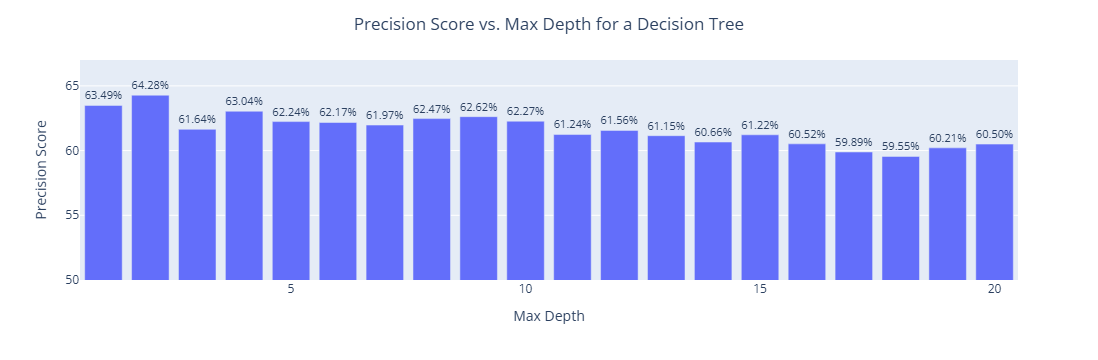

In [87]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[50, 67],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()
     

In [88]:
%%time
clf_4, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=4)


# predict on a full dataset
y_pred_all = clf_4.predict(X_all)


# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred5_clf_4'] = y_pred_all
     

CPU times: user 8.55 s, sys: 0 ns, total: 8.55 s
Wall time: 8.54 s


In [89]:

best_depth = 2
best_precision = precision_by_depth[best_depth]

In [90]:

%%time
clf_best,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)
     

CPU times: user 4.39 s, sys: 0 ns, total: 4.39 s
Wall time: 4.39 s


In [91]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 7
Number of leaves: 4


In [92]:
clf_best

DecisionTreeClassifier(max_depth=2, random_state=42)

In [93]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)
y_pred_clf_best

array([1, 1, 0, ..., 1, 1, 1])

In [94]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_best'] = y_pred_clf_best

In [95]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_sma50', 'pred3_manual_prev_g1_and_sma200', 'pred4_clf_13', 'pred5_clf_4', 'pred6_clf_best']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    563
0    393
Name: count, dtype: int64
is_correct_pred0
1    0.588912
0    0.411088
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9347
0    7821
Name: count, dtype: int64
is_correct_pred1
1    0.544443
0    0.455557
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_sma50 , is_correct_column: is_correct_pred2
is_correct_pred2
1    31
0     8
Name: count, dtype: int64
is_correct_

In [96]:
new_df['pred6_clf_best'].sum()

143084

## **3.3 Random Forest**

In [97]:
from sklearn.ensemble import RandomForestClassifier
import time

In [98]:
# (12 min runtime FOR v28 machine) UNCOMMENT BELOW TO RUN HYPERPARAMs optimisation again
precision_matrix = {}
best_precision = 0
best_depth = 0
best_estimators = 1

for depth in [5, 7, 9, 11, 13, 15, 17, 19, 21]:
  for estimators in [10,50,100,200]:
    print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

    # Start timing
    start_time = time.time()
    # fitting the tree on X_train, y_train
    rf = RandomForestClassifier(n_estimators = estimators,
                                max_depth = depth,
                                random_state = 42,
                                n_jobs = -1)

    rf = rf.fit(X_train_valid, y_train_valid)

    # getting the predictions for TEST and accuracy score
    y_pred_valid = rf.predict(X_valid)
    precision_valid = precision_score(y_valid, y_pred_valid)
    y_pred_test = rf.predict(X_test)
    precision_test = precision_score(y_test, y_pred_test)
    print(f'  Precision on test is {precision_test}, precision on valid (model trained on X_train_valid) is {precision_valid} - tend to overfit)')

    # saving to the dict
    precision_matrix[depth, estimators] = round(precision_test,4)

    # Measure elapsed time
    elapsed_time = time.time() - start_time
    print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

    # updating the best precision
    if precision_test >= best_precision:
      best_precision = round(precision_test,4)
      best_depth = depth
      best_estimators = estimators
      print(f'New best precision found for depth={depth}, estimators = {estimators}')

    print('------------------------------')

print(f'Matrix of precisions: {precision_matrix}')
print(f'The best precision is {best_precision} and the best depth is {best_depth} ')
     

Working with HyperParams: depth = 5, estimators = 10
  Precision on test is 0.6146970815684141, precision on valid (model trained on X_train_valid) is 0.5929814468574716 - tend to overfit)
Time for training: 1.54 seconds, or 0.03 minutes
New best precision found for depth=5, estimators = 10
------------------------------
Working with HyperParams: depth = 5, estimators = 50
  Precision on test is 0.606111867024602, precision on valid (model trained on X_train_valid) is 0.5854008703844946 - tend to overfit)
Time for training: 2.71 seconds, or 0.05 minutes
------------------------------
Working with HyperParams: depth = 5, estimators = 100
  Precision on test is 0.6081221669019841, precision on valid (model trained on X_train_valid) is 0.5885997521685254 - tend to overfit)
Time for training: 4.91 seconds, or 0.08 minutes
------------------------------
Working with HyperParams: depth = 5, estimators = 200
  Precision on test is 0.6089053387169134, precision on valid (model trained on X_tra

In [99]:
# uncomment when you run the hyperparam tuning again
print(precision_matrix)

{(5, 10): 0.6147, (5, 50): 0.6061, (5, 100): 0.6081, (5, 200): 0.6089, (7, 10): 0.6171, (7, 50): 0.614, (7, 100): 0.6178, (7, 200): 0.6191, (9, 10): 0.6151, (9, 50): 0.6239, (9, 100): 0.6246, (9, 200): 0.6247, (11, 10): 0.6154, (11, 50): 0.6241, (11, 100): 0.6263, (11, 200): 0.628, (13, 10): 0.6217, (13, 50): 0.6256, (13, 100): 0.6264, (13, 200): 0.6277, (15, 10): 0.6197, (15, 50): 0.6241, (15, 100): 0.6251, (15, 200): 0.6269, (17, 10): 0.6188, (17, 50): 0.6253, (17, 100): 0.6269, (17, 200): 0.6284, (19, 10): 0.6217, (19, 50): 0.6268, (19, 100): 0.6277, (19, 200): 0.6279, (21, 10): 0.6198, (21, 50): 0.6289, (21, 100): 0.6269, (21, 200): 0.6262}


In [101]:
# pre-calculated best precision matrix (max_depth, n_estimators) for Random Forest ZB20251109, for saving time
precision_matrix = {(5, 10): 0.6147, (5, 50): 0.6061, (5, 100): 0.6081, (5, 200): 0.6089, (7, 10): 0.6171, (7, 50): 0.614, (7, 100): 0.6178, (7, 200): 0.6191, (9, 10): 0.6151, (9, 50): 0.6239, (9, 100): 0.6246, (9, 200): 0.6247, (11, 10): 0.6154, (11, 50): 0.6241, (11, 100): 0.6263, (11, 200): 0.628, (13, 10): 0.6217, (13, 50): 0.6256, (13, 100): 0.6264, (13, 200): 0.6277, (15, 10): 0.6197, (15, 50): 0.6241, (15, 100): 0.6251, (15, 200): 0.6269, (17, 10): 0.6188, (17, 50): 0.6253, (17, 100): 0.6269, (17, 200): 0.6284, (19, 10): 0.6217, (19, 50): 0.6268, (19, 100): 0.6277, (19, 200): 0.6279, (21, 10): 0.6198, (21, 50): 0.6289, (21, 100): 0.6269, (21, 200): 0.6262}

In [102]:
def draw_precisions(precision_matrix, x1=5, x2=22):
    # Convert data to DataFrame
    df = pd.DataFrame.from_dict(precision_matrix, orient='index', columns=['precision_score']).reset_index()
    
    # Rename the columns for clarity
    df.columns = ['max_depth_and_metric', 'precision_score']
    
    # Separate the tuple into two columns
    df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)
    
    # Drop the combined column
    df = df.drop(columns=['max_depth_and_metric'])
    
    # Create line plot using Plotly Express
    fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
                  labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
                  title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')
    
    # Adjust x-axis range
    fig.update_xaxes(range=[x1, x2])
    
    # Show the figure
    fig.show()
     

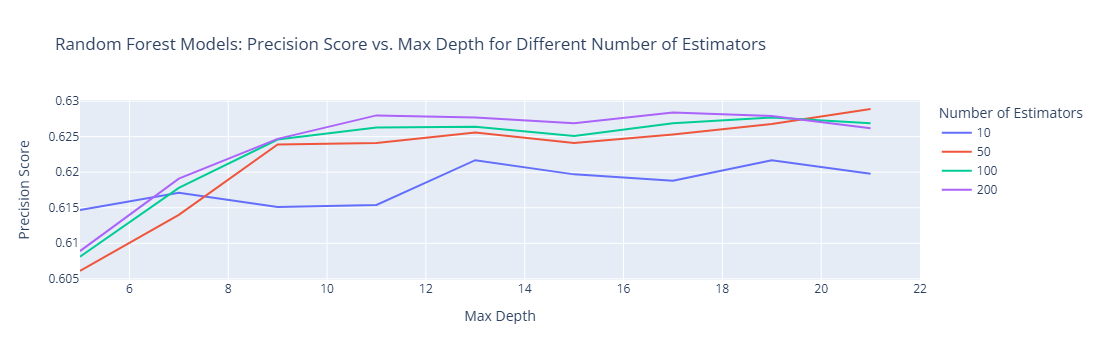

In [103]:
draw_precisions(precision_matrix)

In [104]:
# MANUALLY SELECTED BEST - should have enough complexity and smoothness (n_estimators)
rf_best_n_estimators = 200
# MANUALLY SELECTED BEST - should have enough complexity
rf_best_max_depth = 17

In [105]:
%%time

#
# several minutes to compute (2 min)

rf_best = RandomForestClassifier(n_estimators = rf_best_n_estimators,
                                 max_depth = rf_best_max_depth,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)

CPU times: user 8min 14s, sys: 652 ms, total: 8min 15s
Wall time: 26.1 s


## **3.4 XGboost**

In [106]:
from xgboost import XGBClassifier

In [250]:
# (12 min runtime FOR v28 machine) UNCOMMENT BELOW TO RUN HYPERPARAMs optimisation again
precision_matrix = {}
best_precision = 0
best_depth = 0
best_estimators = 1

for depth in [2, 3, 4, 5, 7]: # Drop with depth increasing , 9, 11, 13, 15, 17, 19, 21]:
  for estimators in [50,100,200]: # 10 is not necessary
    print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

    # Start timing
    start_time = time.time()
    # fitting the tree on X_train, y_train
    xgc = XGBClassifier(objective='binary:logistic', 
                        n_estimators=estimators, 
                        learning_rate=0.1, 
                        max_depth=depth, 
                        random_state=42)

    xgc = xgc.fit(X_train_valid, y_train_valid)

    # getting the predictions for TEST and accuracy score
    y_pred_valid = xgc.predict(X_valid)
    precision_valid = precision_score(y_valid, y_pred_valid)
      
    y_pred_test = xgc.predict(X_test)
    precision_test = precision_score(y_test, y_pred_test)
    print(f'  Precision on test is {precision_test}, precision on valid (model trained on X_train_valid) is {precision_valid} - tend to overfit)')

    # saving to the dict
    precision_matrix[depth, estimators] = round(precision_test,4)

    # Measure elapsed time
    elapsed_time = time.time() - start_time
    print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

    # updating the best precision
    if precision_test >= best_precision:
      best_precision = round(precision_test,4)
      best_depth = depth
      best_estimators = estimators
      print(f'New best precision found for depth={depth}, estimators = {estimators}')

    print('------------------------------')

print(f'Matrix of precisions: {precision_matrix}')
print(f'The best precision is {best_precision} and the best depth is {best_depth} ')
     

Working with HyperParams: depth = 2, estimators = 50
  Precision on test is 0.6205073122366356, precision on valid (model trained on X_train_valid) is 0.6160099356441233 - tend to overfit)
Time for training: 1.11 seconds, or 0.02 minutes
New best precision found for depth=2, estimators = 50
------------------------------
Working with HyperParams: depth = 2, estimators = 100
  Precision on test is 0.6287288951097891, precision on valid (model trained on X_train_valid) is 0.6285882352941177 - tend to overfit)
Time for training: 1.50 seconds, or 0.03 minutes
New best precision found for depth=2, estimators = 100
------------------------------
Working with HyperParams: depth = 2, estimators = 200
  Precision on test is 0.6373047330380042, precision on valid (model trained on X_train_valid) is 0.6412378553436487 - tend to overfit)
Time for training: 2.37 seconds, or 0.04 minutes
New best precision found for depth=2, estimators = 200
------------------------------
Working with HyperParams: d

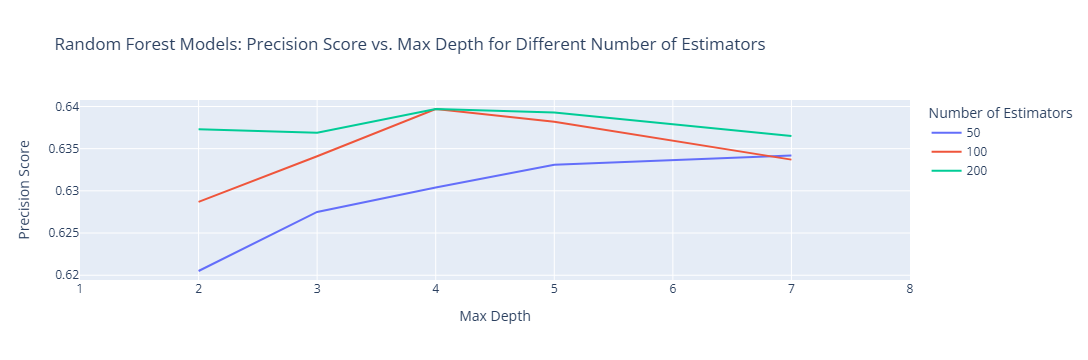

In [253]:
draw_precisions(precision_matrix, x1=1, x2=8)

In [107]:
# MANUALLY SELECTED BEST - should have enough complexity and smoothness (n_estimators)
xgc_best_n_estimators = 200

# MANUALLY SELECTED BEST - should have enough complexity
xgc_best_max_depth = 4 
# The optimal max_depth for XGBoost is typically much smaller than for Random Forests

In [108]:
%%time

xgc_best = XGBClassifier(objective='binary:logistic', 
                        n_estimators=xgc_best_n_estimators, 
                        learning_rate=0.1, 
                        max_depth=xgc_best_max_depth, 
                        random_state=42)

xgc_best = xgc_best.fit(X_train_valid, y_train_valid)

CPU times: user 1min 9s, sys: 221 ms, total: 1min 10s
Wall time: 3.76 s


# **4. Improve precision by varying threshold**

### 4.1 explore

In [109]:
# predicting probability instead of a lable

y_pred_test = rf_best.predict_proba(X_test)
y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

In [110]:
# example prediction of probabilities
y_pred_test
     

array([[0.41727838, 0.58272162],
       [0.42200108, 0.57799892],
       [0.38854956, 0.61145044],
       ...,
       [0.3900696 , 0.6099304 ],
       [0.37336517, 0.62663483],
       [0.38503432, 0.61496568]])

In [111]:
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])
y_pred_test_class1_df.head()
     

,Class1_probability
0,0.582722
1,0.577999
2,0.611450
3,0.567873
4,0.616840


In [112]:
# Mean prediction is 0.54, median is 0.55, 75% quantile is 0.60
y_pred_test_class1_df.describe().T
     

,count,mean,std,min,25%,50%,75%,max
Class1_probability,34761.0,0.542596,0.13124,0.146222,0.452982,0.556509,0.63006,0.960118


In [113]:
# Unconditional probability of a positive growth is 55.5%
y_test.sum()/y_test.count()
     

0.568107937055896

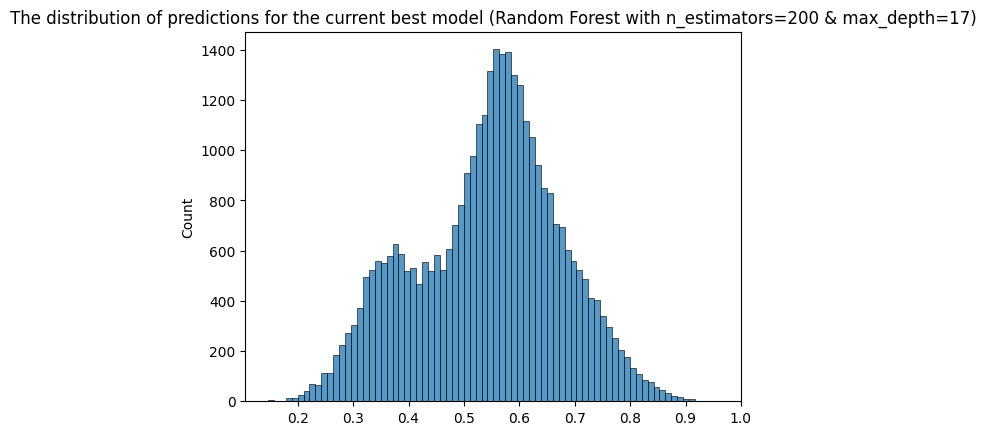

In [114]:
# perfect shape for a Random Forest predictions vs. a Decision Tree - it's an average across many trees (estimators)
sns.histplot(y_pred_test_class1)

# Add a title
plt.title('The distribution of predictions for the current best model (Random Forest with n_estimators=200 & max_depth=17)')

# Show the plot
plt.show()

In [115]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [116]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [117]:
# full df_scores
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,19748,15013,0,0,0.568108,1.000000,0.568108,0.724578,1.000000,1.000000
1,0.02,19748,15013,0,0,0.568108,1.000000,0.568108,0.724578,1.000000,1.000000
2,0.04,19748,15013,0,0,0.568108,1.000000,0.568108,0.724578,1.000000,1.000000
3,0.06,19748,15013,0,0,0.568108,1.000000,0.568108,0.724578,1.000000,1.000000
4,0.08,19748,15013,0,0,0.568108,1.000000,0.568108,0.724578,1.000000,1.000000
5,0.10,19748,15013,0,0,0.568108,1.000000,0.568108,0.724578,1.000000,1.000000
6,0.12,19748,15013,0,0,0.568108,1.000000,0.568108,0.724578,1.000000,1.000000
7,0.14,19748,15013,0,0,0.568108,1.000000,0.568108,0.724578,1.000000,1.000000
8,0.16,19743,15011,5,2,0.568078,0.999747,0.568022,0.724487,0.999747,0.999867
9,0.18,19740,15011,8,2,0.568041,0.999595,0.567935,0.724417,0.999595,0.999867


In [118]:
df_scores[(df_scores.threshold>=0.5) & (df_scores.threshold<=0.8)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
25,0.50,14587,8625,5161,6388,0.628425,0.738657,0.603406,0.679097,0.738657,0.574502
26,0.52,13640,7804,6108,7209,0.636075,0.690703,0.599781,0.662265,0.690703,0.519816
27,0.54,12571,6811,7177,8202,0.648591,0.636571,0.597595,0.642525,0.636571,0.453673
28,0.56,11202,5704,8546,9309,0.662605,0.567247,0.590058,0.611229,0.567247,0.379937
29,0.58,9735,4575,10013,10438,0.680294,0.492961,0.580334,0.571672,0.492961,0.304736
30,0.60,8283,3539,11465,11474,0.700643,0.419435,0.568367,0.524739,0.419435,0.235729
31,0.62,6989,2687,12759,12326,0.722303,0.353909,0.555651,0.475054,0.353909,0.178978
32,0.64,5838,2016,13910,12997,0.743316,0.295625,0.541843,0.423013,0.295625,0.134284
33,0.66,4767,1505,14981,13508,0.760045,0.241392,0.525733,0.366410,0.241392,0.100246
34,0.68,3865,1091,15883,13922,0.779863,0.195716,0.511694,0.312905,0.195716,0.072670


<Axes: title={'center': 'Precision vs. Recall for the Best Model (Random Forest with n_estimators=200 & max_depth=17)'}, xlabel='threshold'>

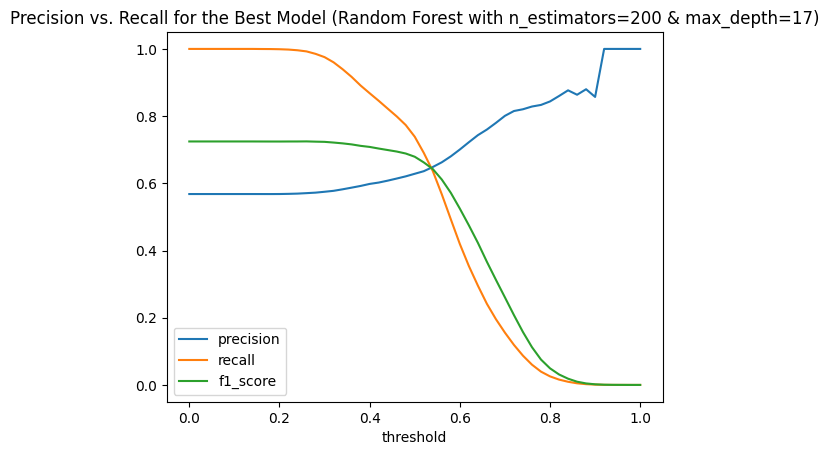

In [119]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Random Forest with n_estimators=200 & max_depth=17)')

### 4.2 predict_proba() for clf_best 

In [149]:
# adding Decision Tree predictors (clf_best) to the dataset for 2 new rules based on thresholds

y_pred_all = clf_best.predict_proba(X_all) # [[0 class, 1 class], [0 class, 1 class], ...,[0 class, 1 class]]
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred8'] = y_pred_all_class1_array
new_df['pred8_clf_second_best_rule_84'] = (y_pred_all_class1_array >= 0.48).astype(int)

new_df['proba_pred9'] = y_pred_all_class1_array
new_df['pred9_clf_second_best_rule_92'] = (y_pred_all_class1_array >= 0.62).astype(int)
     

### 4.3 predict_proba() for rf_best 

In [121]:
# adding Random Forest predictors (rf_best)
rf_best

RandomForestClassifier(max_depth=17, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [122]:
# make predictions of probabilities using the Random Forest model (rf_best)

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list


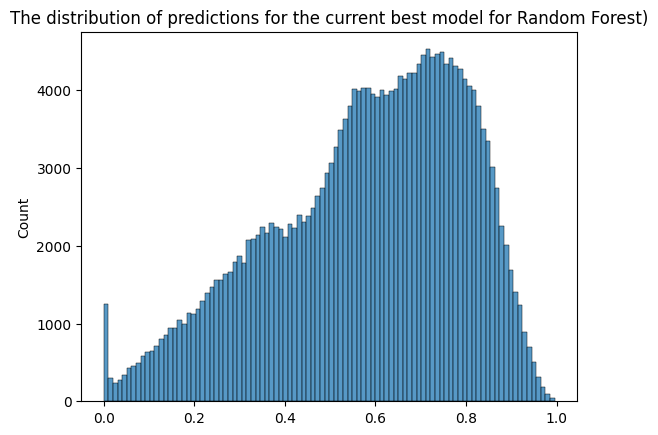

In [123]:
# PREDICTIONS ON A FULL DATASET - different from on a TRAINED SET (too optimistic? or just a bullish environment?)
sns.histplot(y_pred_all_class1)

# Add a title
plt.title('The distribution of predictions for the current best model for Random Forest)')

# Show the plot
plt.show()
     

In [124]:
# adding Random Forest predictors (rf_best) to the dataset for 2 new rules, based on Thresholds
# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred10'] = y_pred_all_class1_array
new_df['pred10_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred11'] = y_pred_all_class1_array
new_df['pred11_rf_best_rule_65'] = (y_pred_all_class1_array >= 0.65).astype(int)
     

<Axes: >

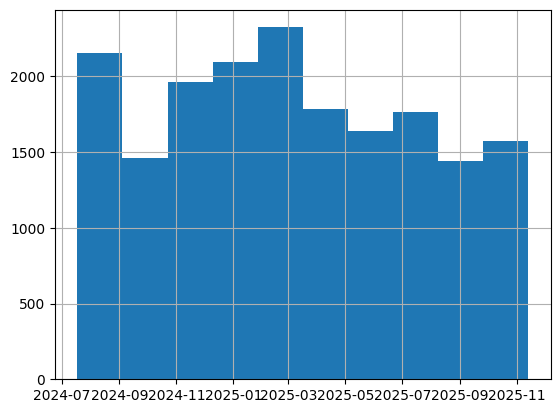

In [125]:
# Many positive predictions
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].Date.hist()

<Axes: >

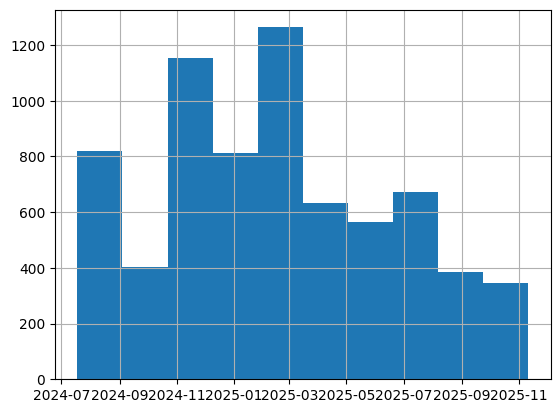

In [126]:
# Vs. less positives on higher-threshold rule
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].Date.hist()
     

In [127]:
# sample of rare predictions with high threshold vs. other predictions
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].sort_values(by='Date').sample(10)

,Open,High,Low,Close,Volume,Ticker,Max_Price_in_future_24h,growth_future_24h,is_positive_growth_24h_future,Year,...,is_correct_pred5,is_correct_pred6,proba_pred8,pred8_clf_second_best_rule_84,proba_pred9,pred9_clf_second_best_rule_92,proba_pred10,pred10_rf_best_rule_55,proba_pred11,pred11_rf_best_rule_65
2025-04-24 19:00:00+00:00,1763.44,1767.26,1756.24,1763.58,2.238605e+04,ETH,1808.51,1.025477,1,2025,...,1,1,0.677774,1,0.677774,1,0.673707,1,0.673707,1
2025-04-23 10:00:00+00:00,1787.76,1810.25,1779.34,1805.96,8.278861e+04,ETH,1815.99,1.005554,0,2025,...,0,0,0.677774,1,0.677774,1,0.669875,1,0.669875,1
2024-09-01 08:00:00+00:00,58411.04,58479.67,58177.13,58237.82,6.011956e+06,BTC,58562.65,1.005578,0,2024,...,1,1,0.479577,0,0.479577,0,0.659921,1,0.659921,1
2025-07-29 10:00:00+00:00,3.16,3.16,3.11,3.12,1.343281e+07,XRP,3.16,1.012821,1,2025,...,1,1,0.677774,1,0.677774,1,0.686449,1,0.686449,1
2024-08-20 13:00:00+00:00,0.61,0.61,0.60,0.60,2.779035e+07,XRP,0.60,1.000000,0,2024,...,0,0,0.677774,1,0.677774,1,0.840481,1,0.840481,1
2024-11-18 11:00:00+00:00,1.15,1.15,1.11,1.12,8.159319e+07,XRP,1.17,1.044643,1,2024,...,1,1,0.677774,1,0.677774,1,0.804018,1,0.804018,1
2025-07-06 14:00:00+00:00,2.28,2.28,2.27,2.27,1.029564e+07,XRP,2.34,1.030837,1,2025,...,0,0,0.479577,0,0.479577,0,0.660052,1,0.660052,1
2025-02-26 23:00:00+00:00,2348.61,2360.76,2322.59,2335.70,4.217946e+04,ETH,2377.61,1.017943,1,2025,...,1,1,0.677774,1,0.677774,1,0.801654,1,0.801654,1
2024-08-19 17:00:00+00:00,0.59,0.60,0.59,0.60,6.451909e+07,XRP,0.61,1.016667,1,2024,...,1,0,0.450432,0,0.450432,0,0.669900,1,0.669900,1
2025-03-29 23:00:00+00:00,2.12,2.14,2.11,2.13,8.061605e+06,XRP,2.20,1.032864,1,2025,...,1,1,0.677774,1,0.677774,1,0.714383,1,0.714383,1


In [128]:
# List of ALL current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS
     

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_sma50',
 'pred3_manual_prev_g1_and_sma200',
 'pred4_clf_13',
 'pred5_clf_4',
 'pred6_clf_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [129]:
# Pred 10: How many positive prediction per day (out of  112 stocks possible)
pred10_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].groupby('Date')['pred11_rf_best_rule_65'].count())
     

In [130]:
# Pred 9: How many positive prediction per day (out of 112 stocks possible)
pred9_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].groupby('Date')['pred10_rf_best_rule_55'].count())
     

In [131]:
# Unique trading days on Test (4 years)
new_df[(new_df.split=='test')].Date.nunique()
     

484

In [132]:
pred10_daily_positive_count

,pred11_rf_best_rule_65
Date,
2024-07-18,26
2024-07-19,22
2024-07-20,18
2024-07-21,15
2024-07-22,15
...,...
2025-11-05,24
2025-11-06,16
2025-11-07,12


array([[<Axes: title={'center': 'pred11_rf_best_rule_65'}>]], dtype=object)

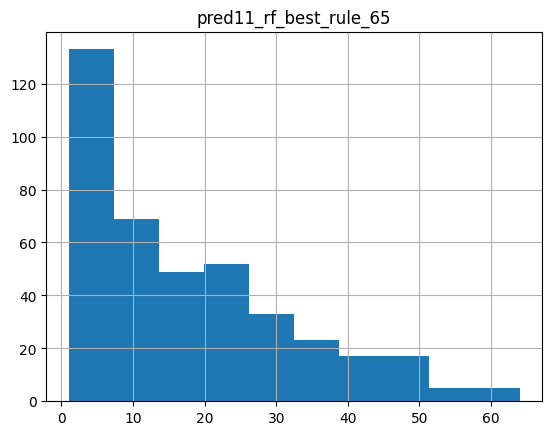

In [133]:
pred10_daily_positive_count.hist()

In [134]:

pred10_daily_positive_count.describe().T
     

,count,mean,std,min,25%,50%,75%,max
pred11_rf_best_rule_65,403.0,17.506203,14.668368,1.0,5.5,13.0,26.0,64.0


In [135]:
pred9_daily_positive_count.describe().T
     

,count,mean,std,min,25%,50%,75%,max
pred10_rf_best_rule_55,480.0,37.9,14.442543,1.0,28.0,41.0,48.0,72.0


### 4.4 predict_proba() for xgc_best

In [151]:
# make predictions of probabilities using the XGBoost model (xgc_best)

y_pred_all = xgc_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list


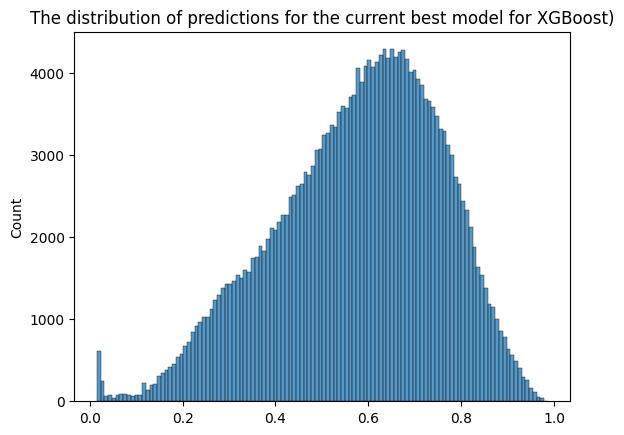

In [152]:
# PREDICTIONS ON A FULL DATASET - different from on a TRAINED SET (too optimistic? or just a bullish environment?)
sns.histplot(y_pred_all_class1)

# Add a title
plt.title('The distribution of predictions for the current best model for XGBoost)')

# Show the plot
plt.show()
     

In [153]:
# adding XGBoost predictors (xgc_best) to the dataset for 2 new rules, based on Thresholds
# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred12'] = y_pred_all_class1_array
new_df['pred12_xgc_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred13'] = y_pred_all_class1_array
new_df['pred13_xgc_best_rule_65'] = (y_pred_all_class1_array >= 0.65).astype(int)

In [154]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict=to_predict)


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_sma50', 'pred3_manual_prev_g1_and_sma200', 'pred4_clf_13', 'pred5_clf_4', 'pred6_clf_best', 'pred8_clf_second_best_rule_84', 'pred9_clf_second_best_rule_92', 'pred10_rf_best_rule_55', 'pred11_rf_best_rule_65', 'pred12_xgc_best_rule_55', 'pred13_xgc_best_rule_65']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10', 'is_correct_pred11', 'is_correct_pred12', 'is_correct_pred13']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    563
0    393
Name: count, dtype: int64
is_correct_pred0
1    0.588912
0    0.411088
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_corr

In [137]:
# check approx. periods : Train, Valid , Test
new_df.groupby('split').Date.agg(['min','max'])

,min,max
split,,
test,2024-07-18,2025-11-13
train,2017-01-16,2023-03-22
validation,2023-03-23,2024-07-17


In [138]:
test = new_df[new_df.split == "test"]
test[test.Ticker == "BTC"]

,Open,High,Low,Close,Volume,Ticker,Max_Price_in_future_24h,growth_future_24h,is_positive_growth_24h_future,Year,...,proba_pred9,pred9_clf_second_best_rule_92,proba_pred10,pred10_rf_best_rule_55,proba_pred11,pred11_rf_best_rule_65,is_correct_pred8,is_correct_pred9,is_correct_pred10,is_correct_pred11
2024-07-18 00:00:00+00:00,64075.920000,64520.980000,63899.970000,64461.660000,8.553123e+06,BTC,64998.94000,1.008335,0,2024,...,0.479577,0,0.582722,1,0.582722,0,1,1,0,1
2024-07-18 01:00:00+00:00,64461.660000,64650.500000,64359.970000,64641.510000,6.501172e+06,BTC,64998.94000,1.005529,0,2024,...,0.479577,0,0.577999,1,0.577999,0,1,1,0,1
2024-07-18 02:00:00+00:00,64641.510000,65138.490000,64235.550000,64683.490000,2.343890e+07,BTC,64998.94000,1.004877,0,2024,...,0.479577,0,0.611450,1,0.611450,0,1,1,0,1
2024-07-18 03:00:00+00:00,64683.490000,64942.970000,64603.970000,64852.480000,5.310040e+06,BTC,64998.94000,1.002258,0,2024,...,0.479577,0,0.567873,1,0.567873,0,1,1,0,1
2024-07-18 04:00:00+00:00,64852.480000,64863.380000,64530.000000,64551.000000,4.503488e+06,BTC,64998.94000,1.006939,0,2024,...,0.479577,0,0.616840,1,0.616840,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-13 01:00:00+00:00,101844.812500,102522.289062,101844.812500,102002.398438,1.069945e+09,BTC,103692.09375,1.016565,1,2025,...,0.479577,0,0.389420,0,0.389420,0,0,0,0,0
2025-11-13 02:00:00+00:00,101980.757812,102328.398438,101980.757812,102056.398438,0.000000e+00,BTC,103692.09375,1.016027,1,2025,...,0.479577,0,0.369924,0,0.369924,0,0,0,0,0
2025-11-13 03:00:00+00:00,102061.351562,102455.125000,101027.640625,102291.656250,1.919820e+09,BTC,103692.09375,1.013691,1,2025,...,0.479577,0,0.414448,0,0.414448,0,0,0,0,0
2025-11-13 04:00:00+00:00,102245.148438,102351.617188,101760.898438,102140.968750,3.434734e+09,BTC,103692.09375,1.015186,1,2025,...,0.479577,0,0.396799,0,0.396799,0,0,0,0,0


In [139]:
# Extract number from the prediction column

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))

10
10


In [155]:
# all predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_sma50',
 'pred3_manual_prev_g1_and_sma200',
 'pred4_clf_13',
 'pred5_clf_4',
 'pred6_clf_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65',
 'pred12_xgc_best_rule_55',
 'pred13_xgc_best_rule_65']

In [156]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
PREDICTIONS_ON_MODELS
    

['pred5_clf_4',
 'pred6_clf_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65',
 'pred12_xgc_best_rule_55',
 'pred13_xgc_best_rule_65']

In [142]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]
IS_CORRECT_ON_MODELS

['is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10',
 'is_correct_pred11']

In [157]:
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred5_clf_4                   count  34761.000000  161674.000000  34776.000000
                              sum    20088.000000  122314.000000  13671.000000
                              mean       0.577889       0.756547      0.393116
pred6_clf_best                count  34761.000000  161674.000000  34776.000000
                              sum    18327.000000  113625.000000  11132.000000
                              mean       0.527229       0.702803      0.320106
pred8_clf_second_best_rule_84 count  34761.000000  161674.000000  34776.000000
                              sum    18327.000000  113625.000000  11132.000000
                              mean       0.527229       0.702803      0.320106
pred9_clf_second_best_rule_92 count  34761.000000  161674.000000  34776.000000
                              sum    18327.000000  113625.000000  11132.000000
                              mean       0.527229       0.702803      0.320106
pred10_rf_best_rule_55        count  34761.000000  161674.000000  34776.000000
                              sum    18192.000000  105856.000000  16091.000000
                              mean       0.523345       0.654750      0.462704
pred11_rf_best_rule_65        count  34761.000000  161674.000000  34776.000000
                              sum     7055.000000   82621.000000  11194.000000
                              mean       0.202957       0.511035      0.321889
pred12_xgc_best_rule_55       count  34761.000000  161674.000000  34776.000000
                              sum    17004.000000  108633.000000  13032.000000
                              mean       0.489169       0.671926      0.374741
pred13_xgc_best_rule_65       count  34761.000000  161674.000000  34776.000000
                              sum     8623.000000   73894.000000   6523.000000
                              mean       0.248065       0.457056      0.187572

In [158]:
# 11 predictions stats (check TEST set)
new_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T

split                                          test          train  \
pred0_manual_cci                count  34761.000000  161674.000000   
                                sum      956.000000    4256.000000   
                                mean       0.027502       0.026325   
pred1_manual_prev_g1            count  34761.000000  161674.000000   
                                sum    17168.000000   74721.000000   
                                mean       0.493887       0.462171   
pred2_manual_prev_g1_and_sma50  count  34761.000000  161674.000000   
                                sum       39.000000     767.000000   
                                mean       0.001122       0.004744   
pred3_manual_prev_g1_and_sma200 count  34761.000000  161674.000000   
                                sum     1199.000000    8501.000000   
                                mean       0.034493       0.052581   
pred4_clf_13                    count  34761.000000  161674.000000   
                                sum    23943.000000  122055.000000   
                                mean       0.688789       0.754945   
pred5_clf_4                     count  34761.000000  161674.000000   
                                sum    20088.000000  122314.000000   
                                mean       0.577889       0.756547   
pred6_clf_best                  count  34761.000000  161674.000000   
                                sum    18327.000000  113625.000000   
                                mean       0.527229       0.702803   
pred8_clf_second_best_rule_84   count  34761.000000  161674.000000   
                                sum    18327.000000  113625.000000   
                                mean       0.527229       0.702803   
pred9_clf_second_best_rule_92   count  34761.000000  161674.000000   
                                sum    18327.000000  113625.000000   
                                mean       0.527229       0.702803   
pred10_rf_best_rule_55          count  34761.000000  161674.000000   
                                sum    18192.000000  105856.000000   
                                mean       0.523345       0.654750   
pred11_rf_best_rule_65          count  34761.000000  161674.000000   
                                sum     7055.000000   82621.000000   
                                mean       0.202957       0.511035   
pred12_xgc_best_rule_55         count  34761.000000  161674.000000   
                                sum    17004.000000  108633.000000   
                                mean       0.489169       0.671926   
pred13_xgc_best_rule_65         count  34761.000000  161674.000000   
                                sum     8623.000000   73894.000000   
                                mean       0.248065       0.457056   

split                                    validation  
pred0_manual_cci                count  34776.000000  
                                sum      966.000000  
                                mean       0.027778  
pred1_manual_prev_g1            count  34776.000000  
                                sum    15884.000000  
                                mean       0.456752  
pred2_manual_prev_g1_and_sma50  count  34776.000000  
                                sum       18.000000  
                                mean       0.000518  
pred3_manual_prev_g1_and_sma200 count  34776.000000  
                                sum      730.000000  
                                mean       0.020991  
pred4_clf_13                    count  34776.000000  
                                sum    19072.000000  
                                mean       0.548424  
pred5_clf_4                     count  34776.000000  
                                sum    13671.000000  
                                mean       0.393116  
pred6_clf_best                  count  34776.000000  
                                sum    11132.000000  
                                mean       0.320106  
pred8_clf_s

In [159]:
new_df

,Open,High,Low,Close,Volume,Ticker,Max_Price_in_future_24h,growth_future_24h,is_positive_growth_24h_future,Year,...,is_correct_pred8,is_correct_pred9,is_correct_pred10,is_correct_pred11,proba_pred12,pred12_xgc_best_rule_55,proba_pred13,pred13_xgc_best_rule_65,is_correct_pred12,is_correct_pred13
2017-01-16 00:00:00+00:00,821.440000,833.820000,811.560000,833.150000,2.439986e+05,BTC,838.840000,1.006830,0,2017,...,0,0,0,1,0.749348,1,0.749348,1,0,0
2017-01-16 01:00:00+00:00,833.150000,833.850000,812.320000,830.800000,9.150589e+05,BTC,838.840000,1.009677,0,2017,...,0,0,0,1,0.723553,1,0.723553,1,0,0
2017-01-16 02:00:00+00:00,830.800000,838.840000,825.560000,838.840000,9.587638e+05,BTC,838.840000,1.000000,0,2017,...,1,1,1,1,0.668896,1,0.668896,1,0,0
2017-01-16 03:00:00+00:00,838.840000,838.870000,826.740000,831.090000,3.013861e+05,BTC,834.730000,1.004380,0,2017,...,0,0,0,1,0.749641,1,0.749641,1,0,0
2017-01-16 04:00:00+00:00,831.090000,838.980000,825.420000,828.270000,2.369731e+05,BTC,850.000000,1.026235,1,2017,...,1,1,1,1,0.722207,1,0.722207,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-13 01:00:00+00:00,2.390513,2.414428,2.390513,2.404592,6.791168e+06,XRP,2.504333,1.041479,1,2025,...,1,1,1,0,0.467379,0,0.467379,0,0,0
2025-11-13 02:00:00+00:00,2.404756,2.421883,2.404617,2.421062,0.000000e+00,XRP,2.504333,1.034395,1,2025,...,1,1,0,0,0.452509,0,0.452509,0,0,0
2025-11-13 03:00:00+00:00,2.421283,2.501146,2.405808,2.498017,4.033075e+08,XRP,2.504333,1.002528,0,2025,...,0,0,0,1,0.557951,1,0.557951,0,0,1
2025-11-13 04:00:00+00:00,2.494352,2.494352,2.459990,2.474395,3.127137e+08,XRP,2.504333,1.012099,1,2025,...,1,1,1,0,0.613593,1,0.613593,0,1,0


In [160]:

filename = "new_df_20251119.joblib"
path = os.path.join(data_dir, filename)
joblib.dump(new_df, path)


['../scripts/data/new_df_20251119.joblib']

In [141]:
pwd

'/home/baozh166/2025Fall_QR_Crypto/notebooks'

In [142]:
data_dir

'../scripts/data'

In [170]:
new_df[new_df.split=='test']

,Open,High,Low,Close,Volume,Ticker,Year,Month,Weekday,Date,...,proba_pred9,pred9_clf_second_best_rule_92,proba_pred10,pred10_rf_best_rule_55,proba_pred11,pred11_rf_best_rule_65,is_correct_pred8,is_correct_pred9,is_correct_pred10,is_correct_pred11
2024-07-12 00:00:00+00:00,57320.010000,57546.830000,57128.050000,57147.510000,4.989356e+06,BTC,2024,7,4,2024-07-12,...,0.568071,0,0.620674,1,0.620674,0,1,0,1,0
2024-07-12 01:00:00+00:00,57147.510000,57327.970000,56525.000000,56921.010000,2.895983e+07,BTC,2024,7,4,2024-07-12,...,0.568071,0,0.523442,0,0.523442,0,1,0,0,0
2024-07-12 02:00:00+00:00,56921.010000,57391.840000,56864.050000,57363.890000,6.947563e+06,BTC,2024,7,4,2024-07-12,...,0.568071,0,0.555628,1,0.555628,0,1,0,1,0
2024-07-12 03:00:00+00:00,57363.890000,57363.960000,56856.000000,56896.500000,8.843572e+06,BTC,2024,7,4,2024-07-12,...,0.568071,0,0.639873,1,0.639873,0,1,0,1,0
2024-07-12 04:00:00+00:00,56896.500000,57054.980000,56702.500000,57025.160000,4.256407e+06,BTC,2024,7,4,2024-07-12,...,0.568071,0,0.608837,1,0.608837,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-09 01:00:00+00:00,2.273429,2.284037,2.272393,2.284037,0.000000e+00,XRP,2025,11,6,2025-11-09,...,0.470288,0,0.504970,0,0.504970,0,0,0,0,0
2025-11-09 02:00:00+00:00,2.284134,2.284134,2.258852,2.258852,0.000000e+00,XRP,2025,11,6,2025-11-09,...,0.470288,0,0.574680,1,0.574680,0,0,0,1,0
2025-11-09 03:00:00+00:00,2.259083,2.262682,2.244558,2.253682,0.000000e+00,XRP,2025,11,6,2025-11-09,...,0.470288,0,0.554377,1,0.554377,0,0,0,1,0
2025-11-09 04:00:00+00:00,2.253621,2.263672,2.253621,2.261516,0.000000e+00,XRP,2025,11,6,2025-11-09,...,0.470288,0,0.498876,0,0.498876,0,0,0,0,0
